<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/ParEGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt


In [9]:

# --- Define KNO1 objective functions ---
def compute_r(x1, x2):
    term1 = 3 * np.sin(5 / (2 * (x1 + x2)**2))
    term2 = 3 * np.sin(4 * (x1 + x2))
    term3 = 5 * np.sin(2 * (x1 + x2) + 2)
    return 9 - (term1 + term2 + term3)

def compute_phi(x1, x2):
    return np.pi / (12 * (x1 - x2 + 3))

def kno1_f1(x):
    r = compute_r(x[0], x[1])
    phi = compute_phi(x[0], x[1])
    return 20 - r * np.cos(phi)

def kno1_f2(x):
    r = compute_r(x[0], x[1])
    phi = compute_phi(x[0], x[1])
    return 20 - r * np.sin(phi)

# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(x, surrogate_f1, surrogate_f2, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    f1_pred = surrogate_f1.predict([x])[0]
    f2_pred = surrogate_f2.predict([x])[0]

    # Tchebycheff scalarization
    scalar_value = max(weights[0] * f1_pred, weights[1] * f2_pred)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_pred + weights[1] * f2_pred)

    return scalar_value


# --- Initialize random population ---
def initialize_population(pop_size, bounds):
    """
    outputs a matrix of mxn, where:
    m => number of (random) samples
    n => sampled values of the nth variable, we have 2 vars here so; mx2.

    This is where we would place a latin hypercube routine
    to select initial points

    Note that each row, correspondes to 1 scalar point for each objective


    """
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] <= f1_vals[i] and f2_vals[j] <= f2_vals[i]) and (f1_vals[j] < f1_vals[i] or f2_vals[j] < f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)

# --- ParEGO Main Loop ---
def par_ego(num_generations, pop_size, bounds):
    population = initialize_population(pop_size, bounds)

    f1_vals = np.array([kno1_f1(p) for p in population])
    f2_vals = np.array([kno1_f2(p) for p in population])
    # Note that: kno1_f2(p) for p in population loops through each row
    # Each row is a sample. If we have m rows, the length of f1_vals and
    # f2_vals, is m.

    # Initialize where we will store solutions
    pareto_all = []

    for gen in range(num_generations):
        # generation = iteration

        # Train surrogate models
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces
        surrogate_f1 = surrogate_model(population, f1_vals)
        surrogate_f2 = surrogate_model(population, f2_vals)
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        # Optimize surrogate model

        result = differential_evolution(
            scalarized_surrogate_objective,
            bounds=bounds,
            args=(surrogate_f1, surrogate_f2, weights),
            maxiter=20,
            popsize=10,
            seed=42,
            disp=False
        )
        x_new = result.x
        f1_new = kno1_f1(x_new)
        f2_new = kno1_f2(x_new)

        # Add to population
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f"Gen {gen+1} | New f1: {f1_new:.4f}, f2: {f2_new:.4f}")

    return pareto_all[-1], f1_vals, f2_vals



In [7]:
bounds = np.array([[0, 3], [0, 3]])
num_generations = 50
pop_size = 5
population = np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))
for p in population:
  print(p)

[2.2605169  2.27704412]
[1.0699319  2.37814333]
[2.63852428 0.6232017 ]
[0.64974692 0.24698499]
[1.85459355 2.10013455]


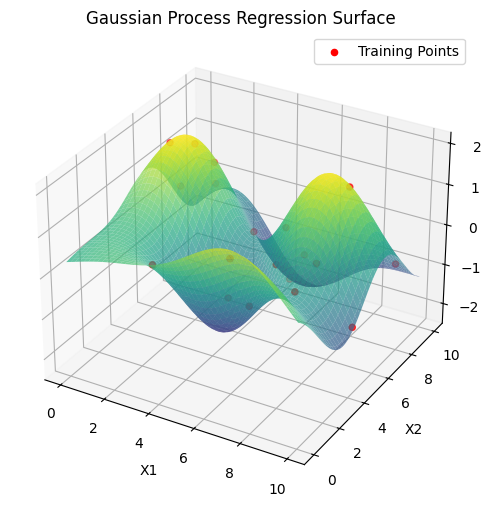

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define your surrogate model
def surrogate_model(X_train, y_train):
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# Training data (example)
X_train = np.random.rand(20, 2) * 10  # Random 2D input
y_train = np.sin(X_train[:, 0]) + np.cos(X_train[:, 1])  # Example function

# Fit the model
gp = surrogate_model(X_train, y_train)

# Create a grid for visualization
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
X_pred = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

# Predict using the GP model
y_pred, sigma = gp.predict(X_pred, return_std=True)
y_pred = y_pred.reshape(X.shape)

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, y_pred, cmap='viridis', alpha=0.7)

# Optionally, plot training points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='red', label='Training Points')

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("y_pred")
plt.title("Gaussian Process Regression Surface")
plt.legend()
plt.show()


In [13]:
# --- Run ParEGO ---
bounds = np.array([[0, 3], [0, 3]])
num_generations = 100 # C iterations
pop_size = 20     # number of initial samples to draw and train the GPs on.

pareto_front, all_f1, all_f2 = par_ego(num_generations, pop_size, bounds)



/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gen 1 | New f1: 5.9103, f2: 17.9803
Gen 2 | New f1: 4.3695, f2: 17.4596
Gen 3 | New f1: 4.2584, f2: 17.4552
Gen 4 | New f1: 4.7060, f2: 17.3696
Gen 5 | New f1: 5.5596, f2: 17.0016
Gen 6 | New f1: 6.2474, f2: 16.6969
Gen 7 | New f1: 11.6305, f2: 17.3128
Gen 8 | New f1: 4.4046, f2: 16.7089
Gen 9 | New f1: 4.3772, f2: 16.7124
Gen 10 | New f1: 4.8575, f2: 16.6755
Gen 11 | New f1: 4.9099, f2: 16.6737
Gen 12 | New f1: 4.7298, f2: 16.6814
Gen 13 | New f1: 4.2919, f2: 16.7249
Gen 14 | New f1: 4.5802, f2: 16.6914
Gen 15 | New f1: 4.3754, f2: 16.7127
Gen 16 | New f1: 4.9313, f2: 16.6730
Gen 17 | New f1: 3.8977, f2: 18.5644
Gen 18 | New f1: 4.7011, f2: 16.6830
Gen 19 | New f1: 4.7788, f2: 16.6789
Gen 20 | New f1: 4.5558, f2: 16.6934
Gen 21 | New f1: 3.7889, f2: 18.0766
Gen 22 | New f1: 4.6209, f2: 16.6883
Gen 23 | New f1: 3.7016, f2: 18.3769
Gen 24 | New f1: 4.9854, f2: 16.6716
Gen 25 | New f1: 3.7052, f2: 18.3731
Gen 26 | New f1: 4.9126, f2: 16.6736
Gen 27 | New f1: 4.8636, f2: 16.6753
Gen 28 | 

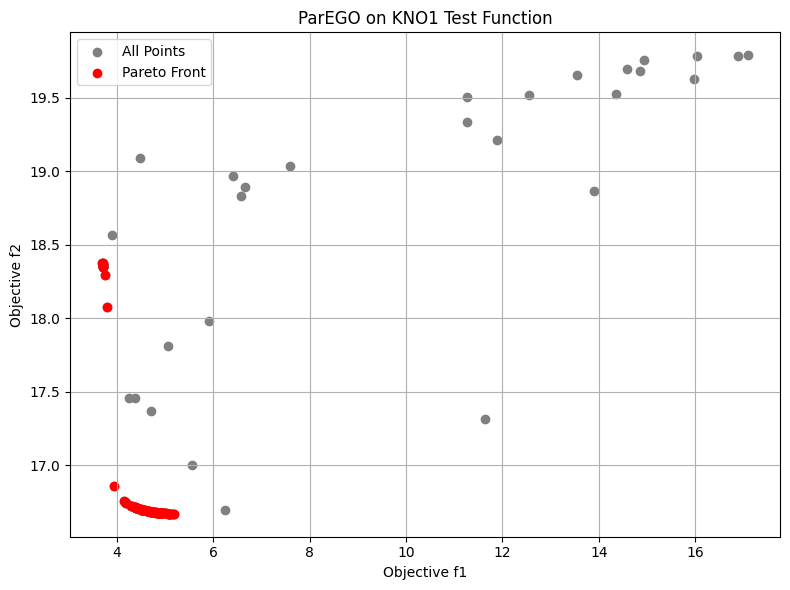

In [14]:
# --- Plot Results ---
plt.figure(figsize=(8, 6))
plt.scatter(all_f1, all_f2, c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Pareto Front")
plt.xlabel("Objective f1")
plt.ylabel("Objective f2")
plt.title("ParEGO on KNO1 Test Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()